<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/PA3_Team1_W23_variant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PA3: k-NN**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda 
*  Tanvir Hossain
*  Ram Dershan

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [177]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [178]:
# Connect to Dataset

#filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"

#df = pd.read_csv(filename)


# load both data sets in
original = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"
df_original = pd.read_csv(original)
additional = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/full_nyc_dataset_cleaned_table-1.csv"
df_additional = pd.read_csv(additional)

In [179]:
# Merge the two datasets with an inner join, validate that no duplicate id values exist for a one to one join
df = pd.merge(df_original, df_additional, how = "inner", on = "id", validate="one_to_one", suffixes=("_original","_additional"))
df.shape

(16005, 22)

In [180]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type_original', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'room_type_additional',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds'],
      dtype='object')

# Data Cleaning

In [181]:
# check value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Shared room in loft                     19
Entire guesthouse                       19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

There are property types that we do not want to consider in our analysis (Boats, Caves and Villa's) so we will remove these examples.

In [182]:
# Check shape before dropping examples
df.shape

(16005, 22)

In [183]:
df = df.drop(df[(df['property_type'] == 'Cave') | (df['property_type'] == 'Boat') | 
                (df['property_type'] == 'Floor') | (df['property_type'] == 'Private room in farm stay') |
                (df['property_type'] == 'Entire villa') | (df['property_type'] == 'Private room in houseboat') |
                (df['property_type'] == 'Private room in villa') | (df['property_type'] == 'Private room in tent') |
                (df['property_type'] == 'Houseboat')].index)

In [184]:
# Check shape after dropping examples
df.shape

(15986, 22)

In [185]:
# assess new value counts for property_type
df['property_type'].value_counts()

Entire rental unit                    6975
Private room in rental unit           5153
Private room in home                   844
Entire home                            513
Entire condo                           418
Private room in townhouse              352
Entire loft                            326
Entire townhouse                       297
Private room in condo                  180
Shared room in rental unit             178
Private room in loft                   149
Entire guest suite                     133
Entire serviced apartment               98
Room in boutique hotel                  68
Room in hotel                           56
Private room in guest suite             37
Entire place                            33
Room in serviced apartment              24
Entire guesthouse                       19
Shared room in loft                     19
Private room                            18
Private room in resort                  17
Private room in bed and breakfast       14
Shared room

In [186]:
# extract the numerical values from the bathroom_text column for consideration 
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Shared half-bath', 0.5, inplace=True)
df['bathrooms_text'].mask(df['bathrooms_text'] == 'Private half-bath', 0.5, inplace=True)
df['bathrooms'] = df['bathrooms_text'].str.extract(r'\b([\d.]+)\b')

In [187]:
# Convert bathroom to float type
df['bathrooms'] = df['bathrooms'].astype(float)

In [188]:
# drop bathroom_text, beds, and duplicated room_type column
df.drop(['bathrooms_text', 'room_type_additional', 'beds'], axis = 1, inplace = True)

In [189]:
# drop suffix from room_type_original
df = df.rename(columns = {'room_type_original' : 'room_type'})

In [190]:
# check for null values
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                          1562
bathrooms                           52
dtype: int64

For bedrooms and bathrooms with null values, fill with zero as properties can have no bedrooms or bathrooms

In [191]:
df[['bedrooms', 'bathrooms']] = df[['bedrooms', 'bathrooms']].fillna(value=0)

In [192]:
# Check null values again to confirm
df.isnull().sum()

id                                   0
name                                11
host_id                              0
host_name                           10
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       3010
reviews_per_month                 3010
calculated_host_listings_count       0
availability_365                     0
property_type                        0
accommodates                         0
bedrooms                             0
bathrooms                            0
dtype: int64

All other columns with null values are not important for this analysis as these columns will be dropped.

# **Feature Scaling**


In [193]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms'],
      dtype='object')

In [194]:
# drop all columns not necessary
# over simplifying for our first iteration

df.drop(['neighbourhood','name','host_name','number_of_reviews','last_review','reviews_per_month',
         'calculated_host_listings_count','id','host_id','latitude','longitude'], axis=1, inplace = True)
# df.drop('a', inplace=True, axis=1)

In [195]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])


In [196]:
#define clean as duplicate
df_clean = df.copy()

### 1. Check extreme values:

a. Define what an extreme value is for each feature, e.g., using boxplots.

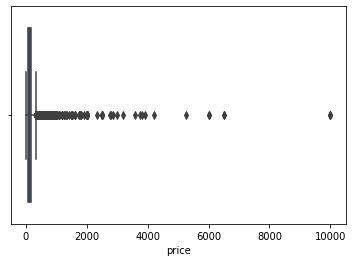

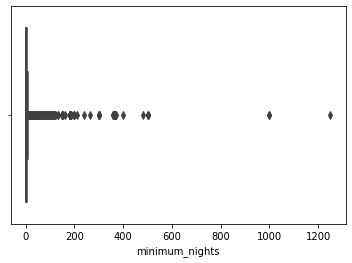

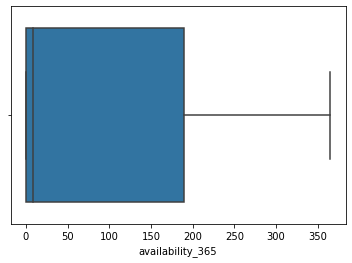

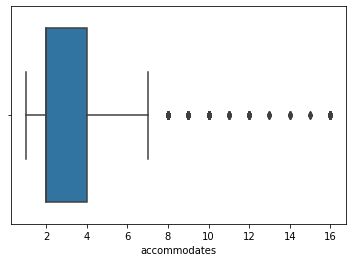

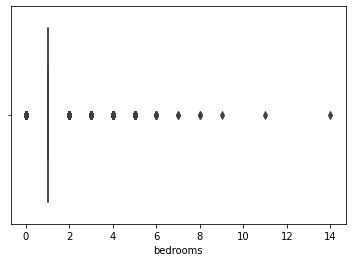

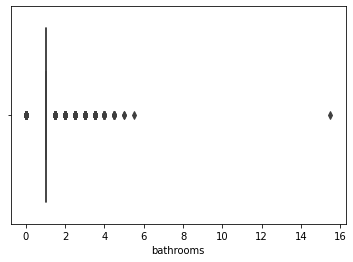

In [197]:
# create boxplots
for column in numeric_data.columns:
    plt.figure()            
    sns.boxplot(numeric_data[column])

In [198]:
# let's try looking at the histograms so the box plots are easier to read
for column in numeric_data.columns:
  fig = px.histogram(df_clean, x=column, marginal="box")
  fig.show()

In [199]:
extreme_values = []

In [200]:
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


In [201]:
extreme_values

[['price', 0, 332.5],
 ['minimum_nights', 0, 11.0],
 ['availability_365', 0, 365.0],
 ['accommodates', 0, 7.0],
 ['bedrooms', 1.0, 1.0],
 ['bathrooms', 1.0, 1.0]]

In [202]:
df_clean.describe(include=['int64' , 'float64']).loc[['std','min','max','75%']]

,price,minimum_nights,availability_365,accommodates,bedrooms,bathrooms
std,239.672142,26.774995,127.801041,1.714661,0.744659,0.402003
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,10000.000000,1250.000000,365.000000,16.000000,14.000000,15.500000
75%,175.000000,5.000000,189.000000,4.000000,1.000000,1.000000


In [203]:
df_clean.describe()


,price,minimum_nights,availability_365,accommodates,bedrooms,bathrooms
count,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000
mean,150.066808,7.832041,96.467659,2.743213,1.169085,1.127768
std,239.672142,26.774995,127.801041,1.714661,0.744659,0.402003
min,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,70.000000,1.000000,0.000000,2.000000,1.000000,1.000000
50%,109.000000,3.000000,8.000000,2.000000,1.000000,1.000000
75%,175.000000,5.000000,189.000000,4.000000,1.000000,1.000000
max,10000.000000,1250.000000,365.000000,16.000000,14.000000,15.500000


In [204]:
# how many rows in our entire data?
df_clean.shape

(15986, 9)

In [205]:
df_clean.dtypes

neighbourhood_group     object
room_type               object
price                    int64
minimum_nights           int64
availability_365         int64
property_type           object
accommodates             int64
bedrooms               float64
bathrooms              float64
dtype: object

b. Do any of your features contain extreme values? List the features & the number of extreme values for each feature.


In [206]:
# confirm standard deviatin for price is too large = needs to drop extreme values
df_clean.describe(include='all').loc['std']

neighbourhood_group           NaN
room_type                     NaN
price                  239.672142
minimum_nights          26.774995
availability_365       127.801041
property_type                 NaN
accommodates             1.714661
bedrooms                 0.744659
bathrooms                0.402003
Name: std, dtype: object

In [207]:
# how many rows our price column?
df_clean.price.count()

15986

In [208]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue


In [209]:
# looking at price specifically 75% is 175 but max is 10,000 so
# what is a good 'extreme' value? boxplot shows this as 374
df_clean.loc[df.price > get_upperfence('price'), 'price'].count()

873

In [210]:
# list of all rows that show price > extreme
df_clean.loc[df.price > get_upperfence('price')]

,neighbourhood_group,room_type,price,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms
22,Manhattan,Entire home/apt,375,180,180,Entire rental unit,4,2.0,2.0
38,Manhattan,Entire home/apt,500,4,243,Entire home,4,3.0,2.0
58,Brooklyn,Entire home/apt,475,3,230,Entire home,11,5.0,2.5
67,Queens,Entire home/apt,350,8,365,Entire townhouse,16,5.0,2.5
92,Manhattan,Entire home/apt,500,4,329,Entire loft,6,3.0,1.0
...,...,...,...,...,...,...,...,...,...
15950,Manhattan,Entire home/apt,400,2,66,Entire condo,4,1.0,1.0
15974,Manhattan,Entire home/apt,430,3,42,Entire rental unit,6,3.0,3.0
15979,Manhattan,Entire home/apt,350,3,8,Entire rental unit,2,1.0,1.0
15985,Manhattan,Entire home/apt,393,30,307,Entire rental unit,4,2.0,2.0


feature = availability_365 shows an extreme value for the value zero, and this really means that unit isn't available so best we just drop those indices to ensure we are only looking at available units!


In [211]:
df_clean['room_type'].value_counts()

Entire home/apt    8803
Private room       6963
Shared room         220
Name: room_type, dtype: int64

In [212]:
df_clean.loc[df.availability_365 == 0, 'availability_365'].count()

7362

In [213]:
df_clean[df_clean.availability_365 == 0]

,neighbourhood_group,room_type,price,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms
1,Brooklyn,Private room,60,45,0,Private room in rental unit,2,1.0,0.0
3,Manhattan,Private room,79,2,0,Private room in rental unit,1,1.0,1.0
7,Brooklyn,Entire home/apt,299,3,0,Entire loft,4,0.0,1.0
33,Brooklyn,Entire home/apt,100,5,0,Entire rental unit,2,1.0,1.0
44,Manhattan,Entire home/apt,100,4,0,Entire rental unit,3,0.0,1.0
...,...,...,...,...,...,...,...,...,...
15691,Queens,Private room,42,2,0,Private room in rental unit,2,1.0,1.0
15729,Manhattan,Entire home/apt,100,1,0,Entire rental unit,3,1.0,1.0
15865,Brooklyn,Private room,60,3,0,Private room in rental unit,1,1.0,1.0
15910,Queens,Private room,59,7,0,Private room in rental unit,2,1.0,1.0


In [214]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Availability_365 percentage over extreme:')
(df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].count() / df_clean.availability_365.count()) * 100 

'Availability_365 percentage over extreme:'

46.052796196672084

In [215]:
df_clean.shape

(15986, 9)

In [216]:
df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].count()

7362

In [217]:
zero_availability = df_clean.loc[df_clean.availability_365 == 0, 'availability_365'].index

In [218]:
# zero availability means unit is NOT available so best drop from out model
df_clean.drop(zero_availability,axis=0,inplace=True)

In [219]:
df_clean.shape

(8624, 9)

Normally dropping 36% of the values would NOT be considered a good solution, but we assuming availability_365 is a range from 0 to 365.  If a unit is 0, this means the owner did not put it for rent for ANY days that year.  So why even offer that as a solution to a potential renter?  We interpret this to mean that 36% of inventory (rooms to rent) were simply not available during this period and that is not part of the business problem we are trying to solve nor analyze.

**BA - This percentage is now 46%**

In [220]:
# dropping availability_365 feature at this stage since it was a filter not a feature
#df_clean.drop(['availability_365'], axis=1, inplace = True)

In [221]:
df_clean.shape

(8624, 9)

c. Do the number of extreme values make-up a substantial portion of that feature? (e.g. 5%) Or are they so few that you could consider dropping those samples? Explain.


In [222]:
df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count()

588

In [223]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df_clean.loc[df_clean.price > get_upperfence('price'), 'price'].count() / df_clean.price.count()) * 100 

'Pricing percentage over extreme:'

6.8181818181818175

Create new df_clean set with the extreme pricing values removed.

In [224]:
df_clean.drop(df_clean[df_clean['price'] > get_upperfence('price')].index, inplace = True)

In [225]:
df_clean.shape

(8036, 9)

In [226]:
# group the prices into categories
# view price
# log price
# break price into 3 groups based on ?? == 
# neighbour_groups becomes the colour background of the heat map
# (dots in the heatmap are the 5 neighbour_groups)

In [227]:
fig = px.histogram(df_clean, df_clean['price'], marginal="box")
fig.show()

Price needs log to get gaussian graph.

In [228]:
# log of zero fails so we count how many have zero, if small, then drop
df_clean.loc[df_clean.price  == 0, 'price'].count()

3

In [229]:
zero_price = df_clean.loc[df_clean.price  == 0, 'price'].index

In [230]:
# zero price rows is low, dropping
df_clean.drop(zero_price,axis=0,inplace=True)

In [231]:
# add log of price to dataframe
df_clean['log_price'] = np.log(df_clean['price'])

In [232]:
fig = px.histogram(df_clean, (df_clean['log_price']), marginal="box")
fig.show()

In [233]:
# break apart price groups by <q1, q1>median, median>q3, q3>
#price_q1 = df_clean['log_price'].quantile(0.25)
#price_mean = df_clean['log_price'].quantile(0.5)
#price_q3 = df_clean['log_price'].quantile(0.75)



In [234]:
# create new price_group text = "budget" or "average" or "high" or "luxury"
# df_clean["price_group"] = 'budget' if df_clean['log_price'] < price_q1 else 'average' if df_clean['log_price'] < price_median else 'high' if df_clean['log_price'] < price_q3 else 'luxury'


In [235]:
df_clean.columns

Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'availability_365', 'property_type', 'accommodates', 'bedrooms',
       'bathrooms', 'log_price'],
      dtype='object')

### 2. Min-max scale your data and store this in a variable name that indicates that you’ve min-max scaled the data, e.g., X_train_minmax.

In [236]:
# Normalization

feature1 = df_clean["log_price"]
feature2 = df_clean["minimum_nights"]
#old: feature3 = df_clean["availability_365"]
feature3 = df_clean["accommodates"]

import sklearn.preprocessing
feature1_STD = feature1.std()
feature2_STD = feature2.std()
feature3_STD = feature3.std()

## create array of each features for processing
feature1_process = df_clean[["log_price"]].values
feature2_process= df_clean[["minimum_nights"]].values
#old: feature3_process = df_clean[["availability_365"]].values
feature3_process = df_clean[["accommodates"]].values

## create standardize and minmax object for each feature
feature1_mm = sklearn.preprocessing.MinMaxScaler()
feature1_mm_scaled = feature1_mm.fit_transform(feature1_process)
feature1_mm_scaled_STD = feature1_mm_scaled.std()

## create standardize and minmax object for each feature
feature2_mm = sklearn.preprocessing.MinMaxScaler()
feature2_mm_scaled = feature1_mm.fit_transform(feature2_process)
feature2_mm_scaled_STD = feature2_mm_scaled.std()

## create standardize and minmax object for each feature
feature3_mm = sklearn.preprocessing.MinMaxScaler()
feature3_mm_scaled = feature3_mm.fit_transform(feature3_process)
feature3_mm_scaled_STD = feature3_mm_scaled.std()

In [237]:
print('feature1 std = ', feature1_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5606523204779298 feature1 mm std =  0.1600597971280925
feature2 std =  34.242702253516185 feature2 mm std =  0.027414388158702375
feature3 std =  1.6444991444521821 feature3 mm std =  0.10962645215337416


### 3. Standardize your data and store this in a variable name that indicates that you’ve standardized the data, e.g., X_train_standard.


In [238]:
# Standard Scalering

#feature 1
feature1_scaler = sklearn.preprocessing.StandardScaler()
feature1_scaled = feature1_scaler.fit_transform(feature1_process)
feature1_scaled_STD = feature1_scaled.std()

#feature 2
feature2_scaler = sklearn.preprocessing.StandardScaler()
feature2_scaled = feature1_scaler.fit_transform(feature2_process)
feature2_scaled_STD = feature2_scaled.std()

#feature 3
feature3_scaler = sklearn.preprocessing.StandardScaler()
feature3_scaled = feature3_scaler.fit_transform(feature3_process)
feature3_scaled_STD = feature3_scaled.std()



In [239]:
print('feature1 std = ', feature1_STD, 'feature1 standardize std = ', feature1_scaled_STD, 'feature1 mm std = ', feature1_mm_scaled_STD)
print('feature2 std = ', feature2_STD, 'feature2 standardize std = ', feature2_scaled_STD, 'feature2 mm std = ', feature2_mm_scaled_STD)
print('feature3 std = ', feature3_STD, 'feature1 standardize std = ', feature3_scaled_STD,'feature3 mm std = ', feature3_mm_scaled_STD)

feature1 std =  0.5606523204779298 feature1 standardize std =  1.0 feature1 mm std =  0.1600597971280925
feature2 std =  34.242702253516185 feature2 standardize std =  1.0 feature2 mm std =  0.027414388158702375
feature3 std =  1.6444991444521821 feature1 standardize std =  1.0 feature3 mm std =  0.10962645215337416


### 4. Visual & numeric comparison 1: Choose 3 features, and compare their standard deviations of after standardizing & min-max scaling. What is the difference between these two approaches on how your features are distributed [Hint: look at the mean].


**Visual comparison**

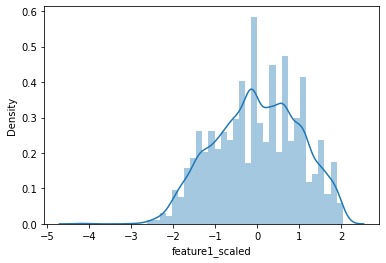

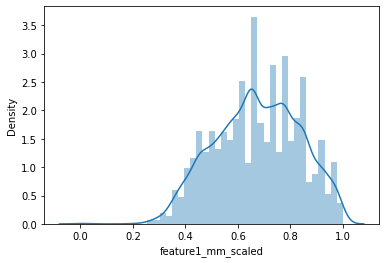

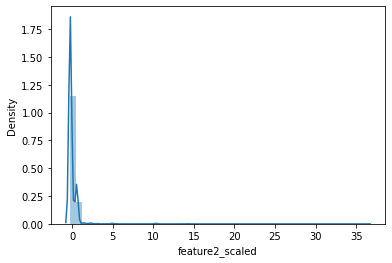

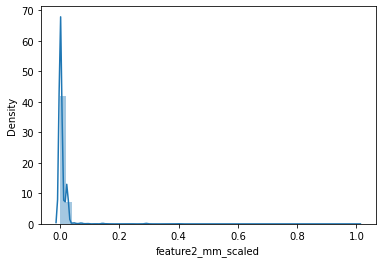

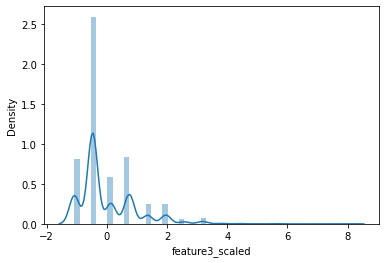

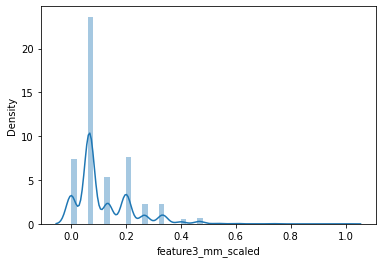

In [240]:
all_features_df = pd.DataFrame({'feature1_scaled':feature1_scaled[:,0], 'feature1_mm_scaled':feature1_mm_scaled[:,0],'feature2_scaled':feature2_scaled[:,0], 'feature2_mm_scaled':feature2_mm_scaled[:,0],'feature3_scaled':feature3_scaled[:,0], 'feature3_mm_scaled':feature3_mm_scaled[:,0]})

for i, column in enumerate(all_features_df.columns, 1):
    sns.distplot(all_features_df[column])
    plt.show()

**Observation:**

From the above graphs, we can notice that in general applying Max-Min Nomaralization in our dataset has generated smaller standard deviations than using Standardisation method. This implies the data are more concentrated around the mean if we scale data using Max-Min Nomaralization.

**Numeric comparison**

In [241]:
all_features_df = pd.DataFrame({'feature1_scaled':feature1_scaled[:,0], 'feature1_mm_scaled':feature1_mm_scaled[:,0],'feature2_scaled':feature2_scaled[:,0], 'feature2_mm_scaled':feature2_mm_scaled[:,0],'feature3_scaled':feature3_scaled[:,0], 'feature3_mm_scaled':feature3_mm_scaled[:,0]})
all_features_df 

,feature1_scaled,feature1_mm_scaled,feature2_scaled,feature2_mm_scaled,feature3_scaled,feature3_mm_scaled
0,1.344821,0.888928,-0.267474,0.000000,-1.080137,0.000000
1,-0.522143,0.590102,-0.238269,0.000801,-0.472011,0.066667
2,-0.309541,0.624131,-0.179859,0.002402,-0.472011,0.066667
3,0.498507,0.753467,-0.238269,0.000801,0.136115,0.133333
4,1.263727,0.875948,-0.238269,0.000801,0.744241,0.200000
...,...,...,...,...,...,...
8028,-0.391567,0.611002,-0.209064,0.001601,-0.472011,0.066667
8029,-0.193169,0.642758,-0.267474,0.000000,-0.472011,0.066667
8030,0.844833,0.808900,-0.267474,0.000000,1.960492,0.333333
8031,-1.200795,0.481477,-0.121449,0.004003,-0.472011,0.066667


**Observation:**

We confirmed that the standard deviations through the process of Max-Min Normalization are smaller in comparison with Standardisation method.

### 5. Visual & numeric comparison 2: Generate a boxplot for all three datasets, the original, the  min-max scaled, and the standardized dataset. We expect to see a comparison like the one in lab, where each box-n-whiskers plot corresponds to a different feature.


In [242]:
df_clean.count()

neighbourhood_group    8033
room_type              8033
price                  8033
minimum_nights         8033
availability_365       8033
property_type          8033
accommodates           8033
bedrooms               8033
bathrooms              8033
log_price              8033
dtype: int64

In [243]:
# test for clean enough data to run k-NN
# zeros denote no nulls
df_clean.isna().sum()

neighbourhood_group    0
room_type              0
price                  0
minimum_nights         0
availability_365       0
property_type          0
accommodates           0
bedrooms               0
bathrooms              0
log_price              0
dtype: int64

In [244]:
df_clean['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [245]:
df_clean.drop(['price'], axis=1, inplace = True)
df_clean

,neighbourhood_group,room_type,minimum_nights,availability_365,property_type,accommodates,bedrooms,bathrooms,log_price
0,Manhattan,Entire home/apt,1,355,Entire rental unit,1,0.0,1.0,5.416100
2,Manhattan,Private room,2,220,Private room in rental unit,2,1.0,1.0,4.369448
4,Brooklyn,Private room,4,314,Private room in townhouse,2,1.0,1.5,4.488636
5,Brooklyn,Entire home/apt,2,46,Entire rental unit,3,0.0,1.0,4.941642
6,Brooklyn,Entire home/apt,2,321,Entire guest suite,4,1.0,1.0,5.370638
...,...,...,...,...,...,...,...,...,...
16000,Queens,Entire home/apt,3,300,Entire home,2,1.0,1.0,4.442651
16001,Manhattan,Private room,1,2,Private room in rental unit,2,1.0,1.0,4.553877
16002,Brooklyn,Entire home/apt,1,363,Entire rental unit,6,2.0,1.0,5.135798
16003,Brooklyn,Private room,6,15,Private room in rental unit,2,1.0,1.0,3.988984


In [246]:
column_names= df_clean.columns
features = column_names[1:]
label = column_names[0]
display(features, label)

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

'neighbourhood_group'

In [247]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

# **Exploring k-NN construction:**

In [248]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [249]:
X_preprocess = make_column_transformer((OrdinalEncoder(), features), remainder='passthrough')
y_preprocess = LabelEncoder()

In [250]:

y = y_preprocess.fit_transform(df_clean[label])
y

array([2, 2, 1, ..., 1, 1, 2])

In [251]:
df_clean.head()
X = X_preprocess.fit_transform(df_clean[features])
# X_new1 = X_preprocess.fit_transform(df_clean[['minimum_nights','log_price']])
X

array([[  0.,   0., 354., ...,   0.,   1., 199.],
       [  1.,   1., 219., ...,   1.,   1.,  57.],
       [  1.,   3., 313., ...,   1.,   2.,  67.],
       ...,
       [  0.,   0., 362., ...,   2.,   1., 147.],
       [  1.,   5.,  14., ...,   1.,   1.,  32.],
       [  1.,   6.,  22., ...,   1.,   3.,  68.]])

In [252]:
X_new = X[:,[1,6]]


In [253]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1. Vary the n_neighbors parameter:

a. Create a k-NN classifier model querying 5 neighbors.

In [255]:
knn_1a = KNeighborsClassifier(n_neighbors=5)
knn_1a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model querying 11 neighbors.

In [256]:
knn_1b = KNeighborsClassifier(n_neighbors=11)
knn_1b.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

c. Create a k-NN classifier model querying 15 neighbors.

In [257]:
knn_1c = KNeighborsClassifier(n_neighbors=15)
knn_1c.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

###2. Vary the weights parameter:

a. Create a k-NN classifier model with weights parameter set to “uniform”.

In [258]:
knn_2a = KNeighborsClassifier(weights = "uniform")
knn_2a.fit(X_train, y_train)

KNeighborsClassifier()

b. Create a k-NN classifier model with weights parameter set to “distance”.

In [259]:
knn_2b = KNeighborsClassifier(weights = "distance")
knn_2b.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

# **k-NN evaluation:**

### 3. Plot the decision boundaries for each class for the different n_neighbors and weights.


In [260]:
# from https://stackoverflow.com/questions/72246343/importerror-cannot-import-name-decisionboundarydisplay-from-sklearn-inspecti
# pip install -U scikit-learn --user

In [261]:
features

Index(['room_type', 'minimum_nights', 'availability_365', 'property_type',
       'accommodates', 'bedrooms', 'bathrooms', 'log_price'],
      dtype='object')

In [262]:
#heatmap_features= (['room_type','log_price'])

In [263]:
len(y)

8033

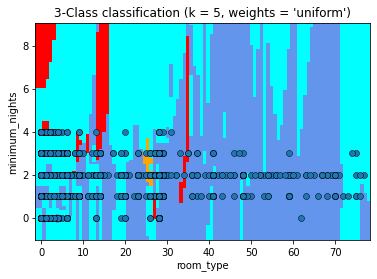

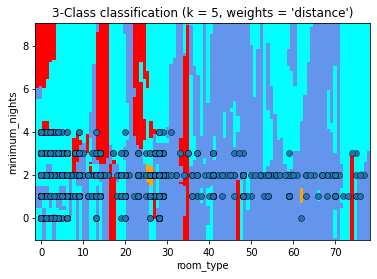

In [264]:
# from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap
# from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = 5

# import some data to play with
# iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
# X and y already defined
# X = iris.data[:, :2]
# y = iris.target


# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue", "red"])
cmap_bold = ["darkorange", "c", "darkblue", "gray"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_new, y)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_new,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=features[0],
        ylabel=features[1],
        shading="auto",
    )

    # Plot also the training points
    sns.scatterplot(
        X_new[:,0],
        y,
        # hue=['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )

plt.show()

### 4. Use the sklearn.metrics.accuracy_score method to compare the accuracy of the several values of k, k=5, 11, and 15, and compare your original and your normalized (min-max scaled and standardized) datasets.


In [265]:
from sklearn.metrics import accuracy_score

In [266]:
yhat_test_1a = knn_1a.predict(X_test)
accuracy_score(y_test, yhat_test_1a)

0.47977598008711886

In [267]:
print("knn_1a Accuracy:",accuracy_score(y_test, yhat_test_1a))

knn_1a Accuracy: 0.47977598008711886


In [268]:
yhat_test_1b = knn_1b.predict(X_test)
accuracy_score(y_test, yhat_test_1b)

0.49595519601742377

In [269]:
print("knn_1b Accuracy:",accuracy_score(y_test, yhat_test_1b))

knn_1b Accuracy: 0.49595519601742377


In [270]:
yhat_test_1c = knn_1c.predict(X_test)
accuracy_score(y_test, yhat_test_1c)

0.5046670815183572

In [271]:
print("knn_1c Accuracy:",accuracy_score(y_test, yhat_test_1c))

knn_1c Accuracy: 0.5046670815183572


In [272]:
yhat_test_2a = knn_2a.predict(X_test)
accuracy_score(y_test, yhat_test_2a)

0.47977598008711886

In [273]:
print("knn_2a Accuracy:", accuracy_score(y_test, yhat_test_2a))

knn_2a Accuracy: 0.47977598008711886


In [274]:
yhat_test_2b = knn_2b.predict(X_test)
accuracy_score(y_test, yhat_test_2b)

0.47666459240821407

In [275]:
print("knn_2b Accuracy:", accuracy_score(y_test, yhat_test_2b))

knn_2b Accuracy: 0.47666459240821407


### 5. Test the performance of each k-NN classifier using other evaluation metrics (precision, recall and F1 scores) and see if there is any difference if you chose different metrics.


In [276]:
from sklearn.metrics import classification_report

In [277]:
y_preprocess.inverse_transform([0,1,2,3,4])

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [278]:
yhat_test_1a = knn_1a.predict(X_test)

In [279]:
print("knn_1a On test data:")
print(classification_report(y_test, yhat_test_1a, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_1a On test data:
               precision    recall  f1-score   support

        Bronx       0.08      0.05      0.06        64
     Brooklyn       0.48      0.63      0.54       677
    Manhattan       0.52      0.50      0.51       575
       Queens       0.43      0.20      0.27       270
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.48      1607
    macro avg       0.30      0.28      0.28      1607
 weighted avg       0.46      0.48      0.46      1607



In [280]:
yhat_test_1b = knn_1b.predict(X_test)

In [281]:
print("knn_1b On test data:")
print(classification_report(y_test, yhat_test_1b, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_1b On test data:
               precision    recall  f1-score   support

        Bronx       0.25      0.03      0.06        64
     Brooklyn       0.48      0.64      0.55       677
    Manhattan       0.54      0.52      0.53       575
       Queens       0.45      0.22      0.30       270
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.50      1607
    macro avg       0.34      0.28      0.29      1607
 weighted avg       0.48      0.50      0.47      1607



In [282]:
yhat_test_1c = knn_1c.predict(X_test)

In [283]:
print("knn_1c On test data:")
print(classification_report(y_test, yhat_test_1c, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_1c On test data:
               precision    recall  f1-score   support

        Bronx       0.20      0.02      0.03        64
     Brooklyn       0.48      0.67      0.56       677
    Manhattan       0.56      0.51      0.53       575
       Queens       0.47      0.22      0.30       270
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.50      1607
    macro avg       0.34      0.28      0.28      1607
 weighted avg       0.49      0.50      0.48      1607



In [284]:
yhat_test_2a = knn_2a.predict(X_test)

In [285]:
print("knn_2a On test data:")
print(classification_report(y_test, yhat_test_2a, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_2a On test data:
               precision    recall  f1-score   support

        Bronx       0.08      0.05      0.06        64
     Brooklyn       0.48      0.63      0.54       677
    Manhattan       0.52      0.50      0.51       575
       Queens       0.43      0.20      0.27       270
Staten Island       0.00      0.00      0.00        21

     accuracy                           0.48      1607
    macro avg       0.30      0.28      0.28      1607
 weighted avg       0.46      0.48      0.46      1607



In [286]:
yhat_test_2b = knn_2b.predict(X_test)

In [287]:
print("knn_2b On test data:")
print(classification_report(y_test, yhat_test_2b, \
                           target_names=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']))

knn_2b On test data:
               precision    recall  f1-score   support

        Bronx       0.04      0.02      0.02        64
     Brooklyn       0.48      0.56      0.52       677
    Manhattan       0.52      0.53      0.53       575
       Queens       0.39      0.30      0.34       270
Staten Island       0.67      0.10      0.17        21

     accuracy                           0.48      1607
    macro avg       0.42      0.30      0.31      1607
 weighted avg       0.47      0.48      0.47      1607



### 6. Imagine that you have another classifier that always predicts the most common label, do a baseline comparison for your ML models.


Baseline

In [288]:
values, counts = np.unique(y_test, return_counts=True)
display(counts.max() / X_test.shape[0])

0.4212818917237088

In [289]:
print("knn_1a Accuracy:",accuracy_score(y_test, yhat_test_1a)) 

knn_1a Accuracy: 0.47977598008711886


In [290]:
print("knn_1b Accuracy:",accuracy_score(y_test, yhat_test_1b))

knn_1b Accuracy: 0.49595519601742377


In [291]:
print("knn_1c Accuracy:",accuracy_score(y_test, yhat_test_1c))

knn_1c Accuracy: 0.5046670815183572


In [292]:
print("knn_2a Accuracy:",accuracy_score(y_test, yhat_test_2a))

knn_2a Accuracy: 0.47977598008711886


In [293]:
print("knn_2b Accuracy:",accuracy_score(y_test, yhat_test_2b))

knn_2b Accuracy: 0.47666459240821407


All the models are better than the baseline

### 7. Generate a simple plot of the test and training learning curve for each k-NN and check if you have a low/high bias or low/high variance learning. We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):


In [294]:
from sklearn.model_selection import learning_curve

In [295]:
data_sizes, training_scores, validation_scores = \
  learning_curve(KNeighborsClassifier(), X_train, \
                 y_train, cv=10, scoring='accuracy', \
                 train_sizes=np.linspace(0.01, 1.0, 51))

In [296]:
display(data_sizes)

array([  57,  172,  286,  401,  515,  630,  744,  859,  973, 1088, 1202,
       1317, 1431, 1546, 1660, 1775, 1889, 2004, 2118, 2233, 2347, 2462,
       2576, 2691, 2805, 2920, 3034, 3149, 3263, 3378, 3492, 3607, 3721,
       3836, 3950, 4065, 4179, 4294, 4408, 4523, 4637, 4752, 4866, 4981,
       5095, 5210, 5324, 5439, 5553, 5668, 5783])

In [297]:
display(training_scores)
display(training_scores.shape)

array([[0.68421053, 0.52631579, 0.52631579, 0.52631579, 0.52631579,
        0.52631579, 0.52631579, 0.52631579, 0.52631579, 0.52631579],
       [0.69186047, 0.56395349, 0.56395349, 0.56395349, 0.56395349,
        0.56395349, 0.56395349, 0.56395349, 0.56395349, 0.56395349],
       [0.66783217, 0.61538462, 0.61538462, 0.61538462, 0.61538462,
        0.61538462, 0.61538462, 0.61538462, 0.61538462, 0.61538462],
       [0.63840399, 0.64339152, 0.64339152, 0.64339152, 0.64339152,
        0.64339152, 0.64339152, 0.64339152, 0.64339152, 0.64339152],
       [0.62330097, 0.61165049, 0.61165049, 0.61165049, 0.61165049,
        0.61165049, 0.61165049, 0.61165049, 0.61165049, 0.61165049],
       [0.64285714, 0.61587302, 0.61587302, 0.61587302, 0.61587302,
        0.61587302, 0.61587302, 0.61587302, 0.61587302, 0.61587302],
       [0.63172043, 0.63844086, 0.63172043, 0.63172043, 0.63172043,
        0.63172043, 0.63172043, 0.63172043, 0.63172043, 0.63172043],
       [0.63213038, 0.63562282, 0.6274738

(51, 10)

In [298]:
display(validation_scores)
display(validation_scores.shape)

array([[0.4525661 , 0.35769829, 0.36547434, 0.37947123, 0.39813375,
        0.40902022, 0.35669782, 0.38006231, 0.36448598, 0.37694704],
       [0.47122862, 0.42301711, 0.43545879, 0.40746501, 0.43234837,
        0.48055988, 0.39719626, 0.45638629, 0.41744548, 0.41900312],
       [0.46034215, 0.45567652, 0.47744946, 0.42923795, 0.44012442,
        0.45878694, 0.4376947 , 0.46884735, 0.45015576, 0.43457944],
       [0.44167963, 0.46967341, 0.48989114, 0.45723173, 0.46034215,
        0.47122862, 0.44548287, 0.4423676 , 0.45950156, 0.43146417],
       [0.45567652, 0.46656299, 0.47433904, 0.47589425, 0.45567652,
        0.48989114, 0.45482866, 0.45482866, 0.45482866, 0.44859813],
       [0.46034215, 0.44634526, 0.46500778, 0.46345257, 0.44790047,
        0.48211509, 0.45327103, 0.46261682, 0.46573209, 0.45015576],
       [0.48055988, 0.42923795, 0.47744946, 0.48055988, 0.45101089,
        0.4836703 , 0.46105919, 0.45794393, 0.45638629, 0.46728972],
       [0.47744946, 0.45101089, 0.4976671

(51, 10)

In [299]:
training_mean = training_scores.mean(axis=1) 
training_standard_deviation = training_scores.std(axis=1) 

In [300]:
validation_mean = validation_scores.mean(axis=1) 
validation_standard_deviation = validation_scores.std(axis=1)

In [301]:
import plotly.graph_objects as go

In [302]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean,
                        mode='lines',
                        name='Training',
                        line=dict(color='red')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean - training_standard_deviation,
                        mode='lines',
                        name='Training lower bound',
                        line=dict(width=0, color='red'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=training_mean + training_standard_deviation,
                        mode='lines',
                        name='Training upper bound',
                        line=dict(width=0, color='red'),
                        fill='tonexty',
                        fillcolor='rgba(255, 0, 0, 0.3)',
                        showlegend=False))

fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean,
                        mode='lines',
                        name='Validation',
                        line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean - validation_standard_deviation,
                        mode='lines',
                        name='Validation lower bound',
                        line=dict(width=0, color='blue'),
                        showlegend=False))
fig.add_trace(go.Scatter(x=data_sizes, 
                        y=validation_mean + validation_standard_deviation,
                        mode='lines',
                        name='Validation upper bound',
                        line=dict(width=0, color='blue'),
                        fill='tonexty',
                        fillcolor='rgba(0, 0, 255, 0.3)',
                        showlegend=False))

fig.update_layout(title='Learning curve',
                 xaxis_title='Dataset size',
                 yaxis_title='Accuracy')
fig.show()